# Predicting Heart Disease

##### By: Matthew Fernandez

## **Introduction**

We will look into the Heart disease data set, and focus mainly on Classification. What are the key features that give us insight of a patient's likelihood of having heart disease? This data set is small, so the methods that will be used may tend to overfit and or produce inaccurate results. However, this is good practice to explore small data sets as they are more typical in real-world scenarios.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix
from scipy.stats import chisquare, chi2_contingency

This data set is from UC Irvine, https://archive.ics.uci.edu/ml/datasets/Statlog+(Heart), obtained on April 15th, 2021.

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/grbruns/cst383/master/heart.csv")
df['output'] = df['output'] - 1

In [3]:
df.describe()

,age,sex,chestpain,restbp,chol,sugar,ecg,maxhr,angina,dep,exercise,fluor,thal,output
count,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.00000,270.000000,270.000000,270.000000,270.000000
mean,54.433333,0.677778,3.174074,131.344444,249.659259,0.148148,1.022222,149.677778,0.329630,1.05000,1.585185,0.670370,4.696296,0.444444
std,9.109067,0.468195,0.950090,17.861608,51.686237,0.355906,0.997891,23.165717,0.470952,1.14521,0.614390,0.943896,1.940659,0.497827
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.00000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,213.000000,0.000000,0.000000,133.000000,0.000000,0.00000,1.000000,0.000000,3.000000,0.000000
50%,55.000000,1.000000,3.000000,130.000000,245.000000,0.000000,2.000000,153.500000,0.000000,0.80000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,280.000000,0.000000,2.000000,166.000000,1.000000,1.60000,2.000000,1.000000,7.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.20000,3.000000,3.000000,7.000000,1.000000


There is 3,780 data values in the entire data set, 270 values per column, and a total of 18 columns. The data set contains 14 initial columns for each patient.

In [4]:
df.isna().sum().sum()

0

There are no NA values in this data set, so there is no need to drop any rows.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        270 non-null    int64  
 1   sex        270 non-null    int64  
 2   chestpain  270 non-null    int64  
 3   restbp     270 non-null    int64  
 4   chol       270 non-null    int64  
 5   sugar      270 non-null    int64  
 6   ecg        270 non-null    int64  
 7   maxhr      270 non-null    int64  
 8   angina     270 non-null    int64  
 9   dep        270 non-null    float64
 10  exercise   270 non-null    int64  
 11  fluor      270 non-null    int64  
 12  thal       270 non-null    int64  
 13  output     270 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 29.7 KB


The data types consist of numberic data types.

## **Initial preprocessing and cleaning**

In [6]:
df.head()

,age,sex,chestpain,restbp,chol,sugar,ecg,maxhr,angina,dep,exercise,fluor,thal,output
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,1
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,0
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,1
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,0
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,0


We can see that categories like sex, chestpain, sugar, ecg, angina, exercise, fluor, and thal have been transformed into numerical data with desciption associated to each value.

Lets remove some values like angina, which covered in chestpain. "fluor" from the dataset short for flouride will also be removed since there is much ambiguity of what that means per patient. 'ecg' is the Electrocardiography of a patient which we are not intrested in, so lets remove it and a few others to make our data set easier to work with.

In [7]:
df.drop(columns =['fluor', 'ecg'], axis = 0, inplace=True)

Does our data set have an imbalanced classification?

In [8]:
df['output'].value_counts()

0    150
1    120
Name: output, dtype: int64

The data set has roughly 55% non heart disease patients and 44% heart disease patients. We can conclude that this data set is not imbalanced. 

## **Exploration and Visualization**

Lets take a look at some numeric variables as we plotting them.

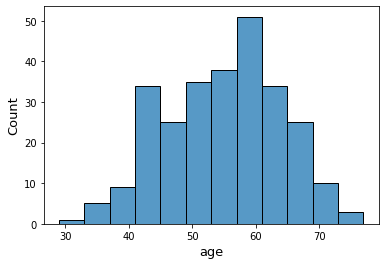

In [9]:
sns.histplot(data=df, x='age')
plt.xlabel('age', fontsize='13')
plt.ylabel('Count', fontsize='13');

The majority of patients are categorized from the early 40s to late 60s. Adults are more likely to suffer from heart disease as opposed to youth.

Lets take a look at what the distribution of max heart rate is for each patient.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


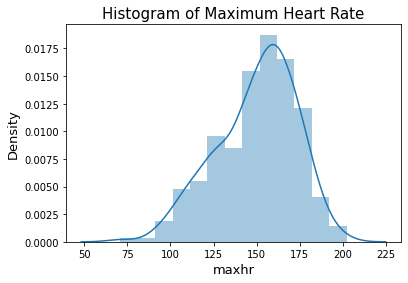

In [10]:
sns.distplot(df['maxhr'])
plt.title('Histogram of Maximum Heart Rate', fontsize='15')
plt.xlabel('maxhr', fontsize='13')
plt.ylabel('Density', fontsize='13');

We may be tempted to now predict that patients with higher the maximum heart rate they achieved, are those individuals that may have a higher probability of having heart disease.

Are there any intresting key take aways from a scatter plot of max heart rate and cholesterol?

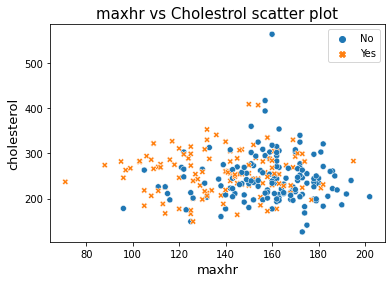

In [11]:
ax = sns.scatterplot(data=df, x='maxhr', y='chol', hue='output', style='output')
legend_labels, _ = ax.get_legend_handles_labels()
ax.legend(legend_labels, ['No','Yes'])
plt.xlabel('maxhr', fontsize='13')
plt.ylabel('cholesterol', fontsize='13')
plt.title('maxhr vs Cholestrol scatter plot', fontsize='15');

An output of 'No' means that the patients do not have heart disease as opposed to those with 'Yes' markers. This scatter plot shows us, there is a higher probability that a patient may have heart disease based on a lower maximum heart. Some unique outliers are within the max heart rate extremes. It is interesting to see that individuals without heart disease typically have a higher maximum heart rate. Cholesterol levels are evenly distributed between 200 through 350, which tells us that cholesterol levels are not very conclusive on a patient's heart disease probability.

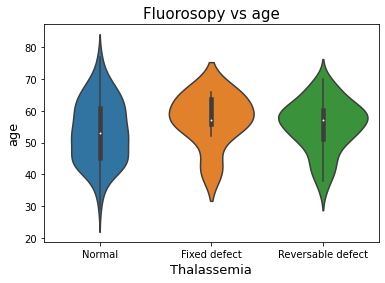

In [12]:
fig, ax = plt.subplots()
sns.violinplot(data=df, y='age', x='thal')
plt.title('Fluorosopy vs age', fontsize='15')
plt.xlabel('Thalassemia', fontsize='13')
plt.ylabel('age', fontsize='13')
labels = ['Normal', 'Fixed defect', 'Reversable defect']
ax.set_xticklabels(labels);

This data set has a similar average age of the three Thalassemia categories. Individuals with thalassemia have a blood disorder caused by DNA mutations, this makes sense as to why our test accuracy dramatically improves when we include thalassemia into our features. 

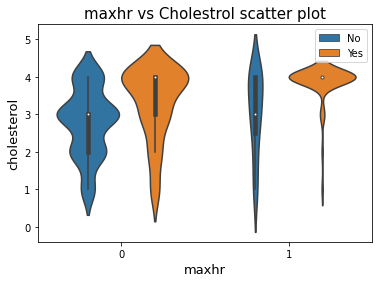

In [13]:
ax = sns.violinplot(data=df, x='angina', y='chestpain', hue='output')
legend_labels, _ = ax.get_legend_handles_labels()
ax.legend(legend_labels, ['No','Yes'])
plt.xlabel('maxhr', fontsize='13')
plt.ylabel('cholesterol', fontsize='13')
plt.title('maxhr vs Cholestrol scatter plot', fontsize='15');

The above violin plot shows that a cholestrol category of 4 has the most significant outcome of heart disease, where as a cholestrol level of 3 is most common for no heart disease. The dot shows that average values per violin plot, and the stem shows the 50% margin of displacement. <br>We will now move onto the machine learning section of our notebook.

## **Machine Learning**

Lets split our data up, 70% for training data and 30% for our test data.

In [14]:
predictors = ['age', 'maxhr', 'chol' , 'thal']
X = df[predictors].values # X is now a np array
y = df['output'].values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.30, random_state=42)
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test) # predict the test set based off of logisitc regression

Lets see how we would do without machine learning as opposed to logistic regression model.

In [15]:
blind_pred = df['output'].value_counts().index[0] # index[0] needed to match length of arrays
baseline_accuracy = (y_test == blind_pred).mean() # how we calc blind prediction
test_accuracy = (y_test == y_pred).mean() # how we obtain val for test accuracy
print('Baseline accuracy: {:.3f} ' .format(baseline_accuracy))
print('test accuracy: {:.3f}'.format(test_accuracy))

Baseline accuracy: 0.605 
test accuracy: 0.802


 Our test set is a much better means at predicting, rather than just blindly predicting if a patient has heart disease or not. Overall we have a better probability of predicting accurately by 20 percent, this is a fantastic model with great features so far.

Let us look at a confusion matrix that will describe the performance of our classification model.

In [16]:
def print_conf_mtx(y_true, y_pred, classes=None):
    """ Print a confusion matrix (two classes only). """
    
    if not classes:
        classes = ['neg', 'pos']
   	 
    # formatting
    max_class_len = max([len(s) for s in classes])
    m = max(max_class_len, len('predicted')//2 + 1)
    n = max(len('actual')+1, max_class_len)
    left   	= '{:<10s}'.replace('10',str(n))
    right  	= '{:>10s}'.replace('10',str(m))
    big_center = '{:^20s}'.replace('20',str(m*2))
    
    cm = confusion_matrix(y_test, y_pred)
    print((left+big_center).format('', 'predicted'))
    print((left+right+right).format('actual', classes[0], classes[1]))
    print((left+right+right).format(classes[0], str(cm[0,0]), str(cm[0,1])))
    print((left+right+right).format(classes[1], str(cm[1,0]), str(cm[1,1])))
# This code was reproduced from Dr. Bruns work
print_conf_mtx(y_test, y_pred)

       predicted 
actual   neg  pos
neg       42    7
pos        9   23


Our model does well, the distribution of True Positive and True Negative is high and False Positive/Negative are both low, we want this to be the case. This means the preformace of our classification model does well at accurately predicting the heart disease per patient.

Lets look at how precision and recall are affected by our model.

In [17]:
TP = (y_pred * y_test).sum()
precision = TP/y_pred.sum()
print('precision : {:.3f}'.format(precision_score(y_test, y_pred)))
recall = TP/y_test.sum()
print('recall : {:.3f}'.format(recall_score(y_test, y_pred)))

precision : 0.767
recall : 0.719


A precision value of .77 and a recall value of .72 shows that the model used performs well with the given features. The percentage of total relevant results is correctly classified 72% of the time(recall), and the percentage of results that are relevant is 77%(precision), fantastic. 

Let us take a look at a probability curve based on the Logistic regression model. 

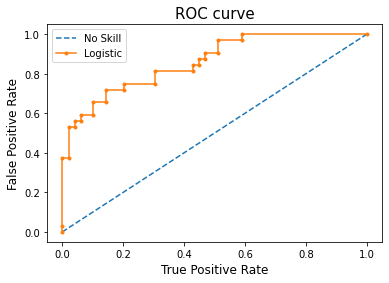

In [18]:
ns_fpr, ns_tpr, _ = roc_curve(y_test, [0 for _ in range(len(y_test))])
lr_fpr, lr_tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:,1]) # 1D array

plt.plot(ns_fpr, ns_tpr, linestyle="--", label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
plt.title('ROC curve', fontsize='15')
plt.xlabel('True Positive Rate', fontsize='12')
plt.ylabel('False Positive Rate', fontsize='12')
plt.legend();
# source: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

The ROC curve tells us the performace of our classification model on the positive class.

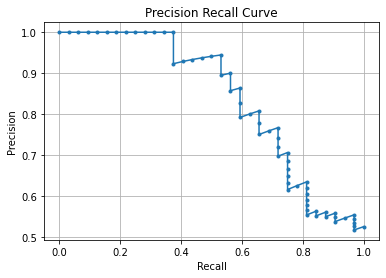

In [19]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, clf.predict_proba(X_test)[:,1])

plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
plt.grid()
plt.title('Precision Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision');
# this code was reproduced through https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

The precision-recall curve allows us to visualize the best value for our model, in this case, it is clear that around precision = 0.75 and recall = 0.7 is our best value we can obtain from the model.

What might our F1-score look like?

In [20]:
f1 = 2 * ((precision*recall)/(precision+recall))
print('F1-score: {:.3f}'.format(f1))

F1-score: 0.742


Our F1-score is the harmonic average of precision and recall. The closer we are to 1, the more concise our model is and therefore the better it performs without the threat of false alarms.

Lets look at the variance of our model.

In [21]:
r = clf.score(X,y) # Based on training data
print('R-squared: {:.2f}'.format(r))

R-squared: 0.78


Our model is performing substantially.

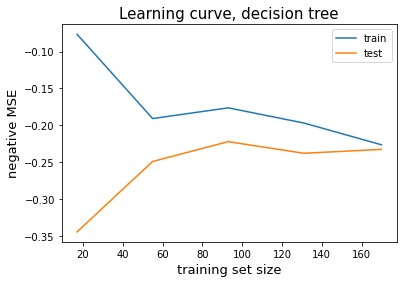

In [22]:
# generate the data; average the values
train_sizes, train_scores, test_scores = learning_curve(clf, X_train, y_train, cv=10,scoring='neg_mean_squared_error') 
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
# plot the learning curve
plt.plot(train_sizes, train_scores_mean, label='train')
plt.plot(train_sizes, test_scores_mean, label='test') 
plt.xlabel('training set size', fontsize='13')
plt.ylabel('negative MSE', fontsize='13')
plt.title('Learning curve, decision tree', fontsize='15')
plt.legend();

Our model has high bias, so this particular prediction is very inaccurate, fortunately we can adjust this.

Our model's mean squared error value is so close to 0, meaning it performs well with the given features. The root mean squared error is also doing great, we want the model to be between 0.2 and 0.5. We can conclude that its ability to predict the data is accurate.

Based on the predictors we chose of 'age', 'maxhr', 'chol' , and 'thal', our model does quite well. We predict a patient has a small probability of having heart disease and the actual data supports our findings. 

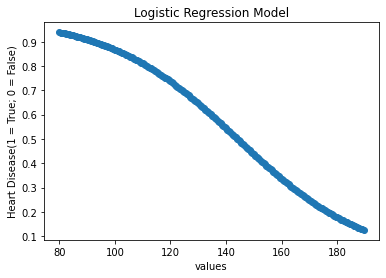

In [23]:
predictions = ['maxhr']
X = df[predictions].values
y = df['output'].values
clf = LogisticRegression()
clf.fit(X,y)
values = np.arange(80, 190, 0.5)
probabilities = []
for i in values:
    p_loss, p_win = clf.predict_proba([[i]])[0]
    probabilities.append(p_win)
plt.scatter(values, probabilities)
plt.title('Logistic Regression Model')
plt.xlabel('values')
plt.ylabel('Heart Disease(1 = True; 0 = False)');

As a patient's maximum heart rate increases, the actual likelihood of that patient having heart disease decreases.

Lets look at every combination of hyperparameters and see how strongly they may or may not be correlate. 

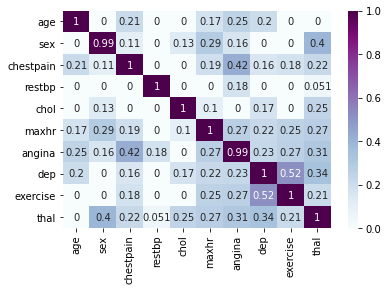

In [24]:
# source: https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9

def cramers_v(x, y):
  confusion_matrix = pd.crosstab(x,y)
  chi2 = chi2_contingency(confusion_matrix)[0]
  n = confusion_matrix.sum().sum()
  phi2 = chi2/n
  r,k = confusion_matrix.shape
  phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
  rcorr = r-((r-1)**2)/(n-1)
  kcorr = k-((k-1)**2)/(n-1)
  return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))



xs = np.array([ 'age', 'sex', 'chestpain', 'restbp', 'chol', 
               'maxhr', 'angina', 'dep', 'exercise','thal'])
n = len(xs)
cor_mtx = np.zeros([n, n])
for i in range(n):
  for j in range(n):
    cor_mtx[i,j] = cramers_v(df[xs[i]], df[xs[j]])

sns.heatmap(cor_mtx, xticklabels=xs, yticklabels=xs, annot=True, cmap="BuPu");

We will change our old features for some new ones that are more strongly correlated and see what happens to our model. Let us choose the predictors that have a heatmap value greater than .25. Will we get a better test accuracy or not?

In [25]:
predictions = ['age', 'dep', 'chestpain', 'angina', 'exercise', 'sex', 'maxhr', 'chol', 'thal']
X = df[predictions].values
y = df['output'].values

X_test, X_train, y_test, y_train = train_test_split(X,y,test_size=0.30, random_state=42)
clf = LogisticRegression()
clf.fit(X,y)
y_pred = clf.predict(X_test)
test_accuracy = (y_test == y_pred).mean()

print('baseline: {:.3f}'.format(baseline_accuracy))
print('test accuracy: {:.3f}'.format(test_accuracy))

baseline: 0.605
test accuracy: 0.815


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Very intersting, our model does one thousandth of a decimal worse than if we're to use all the predictors for our model. Lets make sure that our models precision and recall turns out after we used the selected predictors rather than all of them.


In [26]:
TP = (y_pred * y_test).sum()
precision = TP/y_pred.sum()
print('precision : {:.3f}'.format(precision_score(y_test, y_pred)))
recall = TP/y_test.sum()
print('recall : {:.3f}'.format(recall_score(y_test, y_pred)))

precision : 0.791
recall : 0.818


Our precision and recall score are significantly better proving that our model although has a slightly lower test accuracy, the trade off between the true false positives and true positives are actually much better for our machine learning model. 

## **Conclusion**

We've learned that strongly correlated features do not improve the test accuracy of our model. If we'd like to get a good test accuracy, it is best to train our model with features that are not always apparent at first. For instance, one might initially feel inclined to drop columns from the data set that are not recognized, leading to a bad practice and may lead to biases. This is exactly what I did with the column thalassemia, however, once I included it as a feature, the test accuracy for my model increased dramatically. We also learned that if a patient has a low maximum heart rate, he/she is more probable to having heart disease. After we selected the higher correlated predictors, the machine learning model had a much better trade off with precision and recall scores, this was ideal since we'd like to have the optimal machine learning model. 